In [1]:
import numpy as np
#import pandas as pd 
from keras import utils
from keras import models
from keras import layers
import keras
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import io

In [41]:
#Add more data images
random_bright = keras.layers.RandomBrightness(factor=0.1)
random_contrast = keras.layers.RandomContrast(factor=0.1)
random_flip = keras.layers.RandomFlip(mode="horizontal")
random_rotation = keras.layers.RandomRotation(0.1)

In [19]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
data_path = "ships32"
img_size = 32
batch_size = 32

In [36]:
traindata, validdata = utils.image_dataset_from_directory(
    data_path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_size, img_size),
    shuffle=True,
    validation_split=0.2,
    subset="both",
    seed=1234
)


Found 48330 files belonging to 13 classes.
Using 38664 files for training.
Using 9666 files for validation.


In [42]:
import tensorflow as tf
step1 = traindata.map(lambda x, y: (random_bright(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
step2 = traindata.map(lambda x, y: (random_contrast(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
step3 = traindata.map(lambda x, y: (random_flip(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
step4 = traindata.map(lambda x, y: (random_rotation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
traindata = traindata.concatenate(step1)
traindata = traindata.concatenate(step2)
traindata = traindata.concatenate(step3)
augmented_traindata = traindata.concatenate(step4)

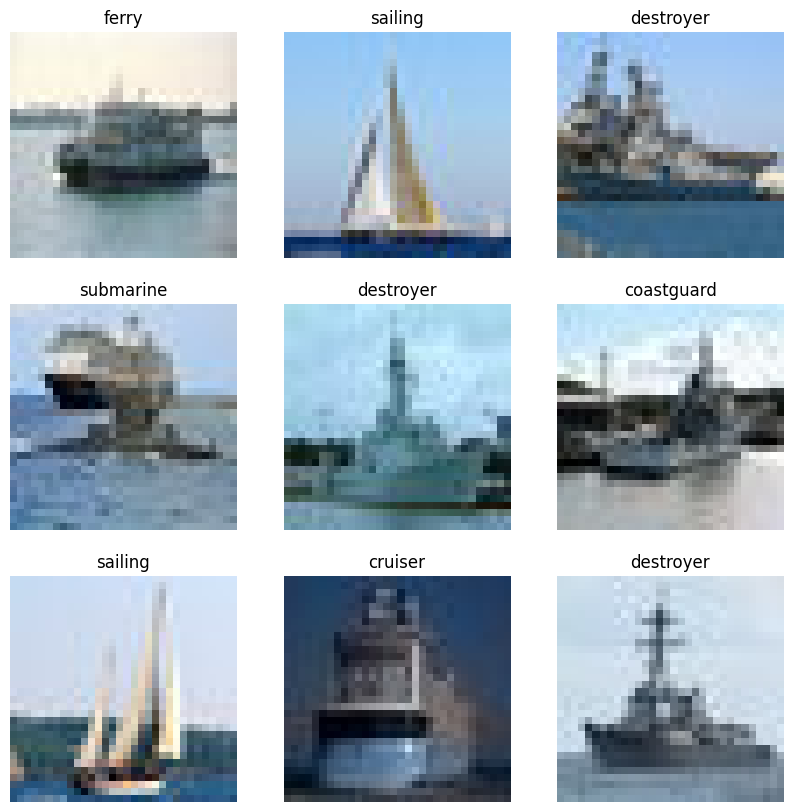

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in traindata.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(traindata.class_names[np.argmax(labels[i])])
        plt.axis("off")

In [32]:
model = models.Sequential()
nfilters = 32
kernel_size = (5,5)
model.add(layers.Input((32,32,3)))
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(nfilters, kernel_size, padding="same"))
model.add(layers.LayerNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(nfilters * 2, kernel_size, padding="same"))
model.add(layers.LayerNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(nfilters * 4, kernel_size, padding="same"))
model.add(layers.LayerNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D())

model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.4))

model.add(layers.Dense(len(traindata.class_names), activation="softmax"))
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (None, 32, 32, 32)     │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_13          │ (None, 16, 16, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_14          │ (None, 8, 8, 128)      │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 13)             │        26,637 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,709 (1.09 MB)

 Trainable params: 285,709 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
len(model.layers)

16

In [43]:
epochs = 10
lr = 0.001

model.compile(optimizer=keras.optimizers.Adam(lr), loss= keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])

history = model.fit(augmented_traindata, epochs=epochs, validation_data=validdata)

#0.6156

Epoch 1/10
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 214s 35ms/step - categorical_accuracy: 0.7354 - loss: 0.7697 - val_categorical_accuracy: 0.7188 - val_loss: 0.8208
Epoch 2/10
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 248s 33ms/step - categorical_accuracy: 0.7986 - loss: 0.5803 - val_categorical_accuracy: 0.7292 - val_loss: 0.7820
Epoch 3/10
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 212s 35ms/step - categorical_accuracy: 0.8355 - loss: 0.4687 - val_categorical_accuracy: 0.7401 - val_loss: 0.7616
Epoch 4/10
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 213s 35ms/step - categorical_accuracy: 0.8645 - loss: 0.3869 - val_categorical_accuracy: 0.7354 - val_loss: 0.7813
Epoch 5/10
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 213s 35ms/step - categorical_accuracy: 0.8839 - loss: 0.3325 - val_categorical_accuracy: 0.7353 - val_loss: 0.7663
Epoch 6/10
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 212s 35ms/step - categorical_accuracy: 0.8988 - loss: 0.2898 - val_categorical_accuracy: 0.7362 - val_loss: 0.7828
Epoch 7/10
6045/6045 ━━━━━━━━━━━━━━━━━━━━ 217s 36ms/step -

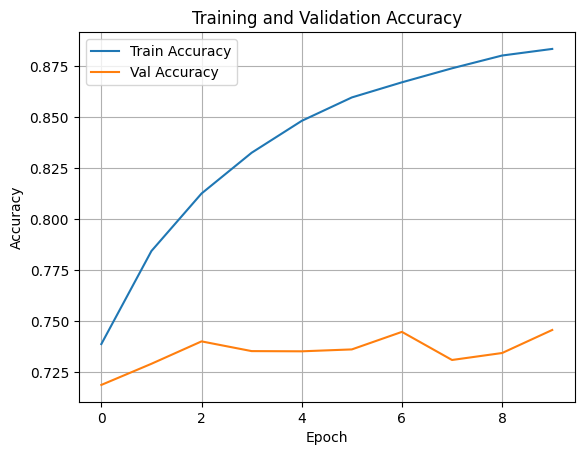

In [44]:
summary_buffer = io.StringIO()
model.summary(print_fn=lambda x: summary_buffer.write(x + "\n"))
summary_text = summary_buffer.getvalue()
with PdfPages("graphs/accuracy_plot3_alexnetLike_FirstTestblaaa.pdf") as pdf:
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)
    pdf.savefig()
    plt.show()
    plt.close()

    fig, ax = plt.subplots(figsize=(8.5, 11)) 
    ax.axis('off')
    plt.text(0, 1, summary_text, fontsize=10, va='top', family='monospace')
    pdf.savefig(fig)
    plt.close()

In [ ]:
model.save("models/alexnetLike_FirstTest.keras")

### Test with alexNet's model adapted:
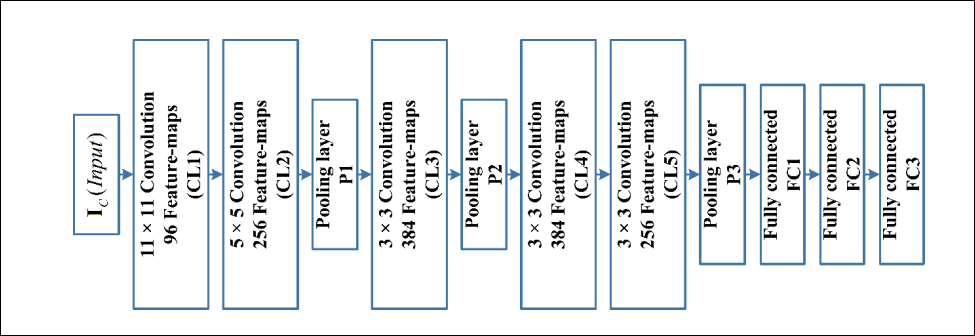

In [ ]:
model = models.Sequential()
model.add(layers.Input((32,32,3)))
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(256, (5,5), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D())

model.add(layers.Conv2D(384, (3,3), padding="same"))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(384, (3,3), padding="same"))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, (3,3), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D())


model.add(layers.Flatten())

model.add(layers.Dense(4096, activation="relu"))
model.add(layers.Dense(len(traindata.class_names), activation="softmax"))

model.summary()